In [9]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# 데이터 불러오기 및 전처리
dfs = {}
keywords = ["auto", "construct", "capital_market", "chemicals", "equipment",
            "transport", "semi", "bank", "steel",
            "telecom", "staples", "discretionary", "kospi"]
for keyword in keywords:
    dfs[keyword] = pd.read_excel(r"total_raw_0.5ver.xlsx", sheet_name=keyword, header=0, index_col=0)
    dfs[keyword].index = pd.to_datetime(dfs[keyword].index)
    dfs[keyword].index = dfs[keyword].index.strftime('%Y-%m-%d')
    dfs[keyword].dropna(inplace=True)

# 특성 선택: 중요한 특성만 사용
selected_features = {}  # 각 키워드별 선택된 특성
for keyword, df in dfs.items():
    X = df.drop(columns=[keyword])  # 종속 변수를 제외한 나머지 특성
    y = df[keyword]  # 종속 변수
    rfc = RandomForestClassifier(random_state=0)
    rfc.fit(X, y)
    selected_feature_indices = np.argsort(rfc.feature_importances_)[::-1][:5]  # 중요한 특성 상위 5개 선택
    selected_features[keyword] = X.columns[selected_feature_indices].tolist()


for keyword, features in selected_features.items():
    print(f"{keyword} 키워드의 선택된 특성들:")
    for feature in features:
        print(feature)
    print()


auto 키워드의 선택된 특성들:
MSCI_EMER_60
구리선물_60
중국고정자산투자(yoy%)_60
금 선물_60
중국 소매판매_60

construct 키워드의 선택된 특성들:
중국고정자산투자(yoy%)_60
MSCI_EMER
VIX
PPI_60
구리선물_60

capital_market 키워드의 선택된 특성들:
중국고정자산투자(yoy%)_60
달러 인덱스_60
PPI_60
WTI_60
T10Y2Y_60

chemicals 키워드의 선택된 특성들:
us_e_infla_60
PPI_60
VIX
원달러
MSCI_EMER

equipment 키워드의 선택된 특성들:
us_e_infla_60
중국고정자산투자(yoy%)_60
yield_gap(%)
VIX
MSCI_EMER

transport 키워드의 선택된 특성들:
중국고정자산투자(yoy%)_60
MSCI_EMER
VIX_60
T10Y2Y_60
달러 인덱스_60

semi 키워드의 선택된 특성들:
treasury_10_3_diff_60
TIPS_60
T10Y2Y_60
중국고정자산투자(yoy%)_60
중국 산업 생산_60

bank 키워드의 선택된 특성들:
MSCI_EMER
중국 소매판매_60
cpi_60
중국 산업 생산_60
DGS10_60

steel 키워드의 선택된 특성들:
VIX
중국 PMI_60
MSCI_EMER
원달러_60
pbr

telecom 키워드의 선택된 특성들:
통신배당_60
TIPS
usa_cpi_60
cpi_60
export_60

staples 키워드의 선택된 특성들:
중국고정자산투자(yoy%)_60
TIPS_60
cpi_60
달러 인덱스_60
usa_cpi_60

discretionary 키워드의 선택된 특성들:
PPI_60
T10Y2Y
usa_cpi_60
중국 소매판매_60
달러 인덱스

kospi 키워드의 선택된 특성들:
중국고정자산투자(yoy%)_60
MSCI_EMER
us_e_infla_60
treasury_10_3_diff_60
중국 소매판매_60



In [16]:
# 예측 시에도 모든 특성을 사용하도록 수정
# 특성 선택: 모든 특성 사용
selected_features = {}  # 각 키워드별 선택된 특성
for keyword, df in dfs.items():
    selected_features[keyword] = df.drop(columns=[keyword]).columns.tolist()  # 모든 특성을 선택

# 모델 학습을 병렬 처리하여 최적 모델 찾기
best_models = {}
for keyword, df in dfs.items():
    X = df[selected_features[keyword]]  # 선택된 모든 특성 사용
    y = df[keyword]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    rfc = RandomForestClassifier(random_state=0)
    param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
    grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[keyword] = grid_search.best_estimator_

for keyword, model in best_models.items():
    print(f"{keyword} 키워드의 최적 모델:")
    print(model)
    print()


auto 키워드의 최적 모델:
RandomForestClassifier(max_depth=20, n_estimators=50, random_state=0)

construct 키워드의 최적 모델:
RandomForestClassifier(n_estimators=50, random_state=0)

capital_market 키워드의 최적 모델:
RandomForestClassifier(n_estimators=150, random_state=0)

chemicals 키워드의 최적 모델:
RandomForestClassifier(max_depth=20, random_state=0)

equipment 키워드의 최적 모델:
RandomForestClassifier(max_depth=20, n_estimators=150, random_state=0)

transport 키워드의 최적 모델:
RandomForestClassifier(random_state=0)

semi 키워드의 최적 모델:
RandomForestClassifier(max_depth=20, n_estimators=150, random_state=0)

bank 키워드의 최적 모델:
RandomForestClassifier(max_depth=20, n_estimators=150, random_state=0)

steel 키워드의 최적 모델:
RandomForestClassifier(max_depth=20, random_state=0)

telecom 키워드의 최적 모델:
RandomForestClassifier(max_depth=20, n_estimators=150, random_state=0)

staples 키워드의 최적 모델:
RandomForestClassifier(random_state=0)

discretionary 키워드의 최적 모델:
RandomForestClassifier(random_state=0)

kospi 키워드의 최적 모델:
RandomForestClassifier(max_dep

In [23]:
# 최적 모델 출력 및 사용
for keyword, model in best_models.items():
    print(f"{keyword} 키워드의 최적 모델:")
    print(model)
    print()

    # RandomForestClassifier 객체 생성 후 출력
    rfc_model = RandomForestClassifier(
        n_estimators=model.n_estimators,
        max_depth=model.max_depth,
        random_state=model.random_state
    )
    print(f"{keyword} 키워드의 RandomForestClassifier 모델:")
    print(rfc_model)
    print()

auto 키워드의 최적 모델:
RandomForestClassifier(max_depth=20, n_estimators=50, random_state=0)

auto 키워드의 RandomForestClassifier 모델:
RandomForestClassifier(max_depth=20, n_estimators=50, random_state=0)

construct 키워드의 최적 모델:
RandomForestClassifier(n_estimators=50, random_state=0)

construct 키워드의 RandomForestClassifier 모델:
RandomForestClassifier(n_estimators=50, random_state=0)

capital_market 키워드의 최적 모델:
RandomForestClassifier(n_estimators=150, random_state=0)

capital_market 키워드의 RandomForestClassifier 모델:
RandomForestClassifier(n_estimators=150, random_state=0)

chemicals 키워드의 최적 모델:
RandomForestClassifier(max_depth=20, random_state=0)

chemicals 키워드의 RandomForestClassifier 모델:
RandomForestClassifier(max_depth=20, random_state=0)

equipment 키워드의 최적 모델:
RandomForestClassifier(max_depth=20, n_estimators=150, random_state=0)

equipment 키워드의 RandomForestClassifier 모델:
RandomForestClassifier(max_depth=20, n_estimators=150, random_state=0)

transport 키워드의 최적 모델:
RandomForestClassifier(random_stat

In [28]:
# 예측 시에도 모든 특성을 사용하도록 수정
probabilities = {}
for keyword, model in best_models.items():
    selected_train_features_keyword = selected_features[keyword]  # 학습할 때 사용된 특성들
    selected_test_features_keyword = [col for col in X_test.columns if col in selected_train_features_keyword]
    # 테스트 데이터 생성에 사용된 특성들을 가져옴
    X_test_keyword = X_test[selected_test_features_keyword]
    # 예측 수행
    y_test_pred = model.predict_proba(X_test_keyword)
    class_probs = np.mean(y_test_pred, axis=0)
    probabilities[keyword] = {'S_sell': class_probs[0], 'hold': class_probs[1], 'S_buy': class_probs[2]}


# 예측 결과 출력
for keyword, probs in probabilities.items():
    print(f"{keyword} Keyword의 확률:")
    print(probs)
    print()

# 그래프로 출력
num_keywords = len(probabilities)
num_rows = (num_keywords + 2) // 3
num_cols = min(num_keywords, 3)
plt.figure(figsize=(6 * num_cols, 4 * num_rows))

for i, (keyword, probs) in enumerate(probabilities.items(), start=1):
    plt.subplot(num_rows, num_cols, i)
    plt.hist(probs.values(), bins=10, color=['skyblue', 'salmon', 'lightgreen'], alpha=0.7)
    plt.title(f'{keyword} Keyword')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)  # Set x-axis limit from 0 to 1

plt.tight_layout()
plt.show()


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- US_auto
- US_auto_20
- US_auto_60
- export_auto
- export_auto_20
- ...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feat

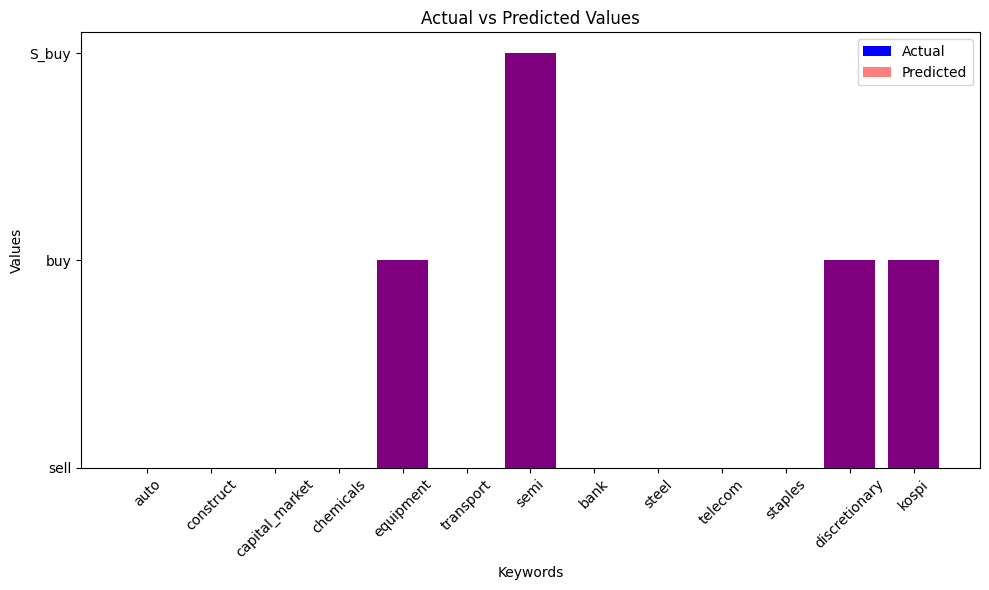

In [7]:
import matplotlib.pyplot as plt

# 주제별 데이터와 예측값 추출
predicted_values = []
actual_values = []
for keyword, model in best_models.items():
    X_test = dfs[keyword][selected_features[keyword]].iloc[-1].values.reshape(1, -1)  # 마지막 행 데이터
    y_test = dfs[keyword].iloc[-1][keyword]
    actual_values.append(y_test)
    predicted_values.append(model.predict(X_test)[0])

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.bar(keywords, actual_values, color='blue', label='Actual')
plt.bar(keywords, predicted_values, color='red', alpha=0.5, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Keywords')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
